# Crest factor analysis
### 07/10/2019
### Laurent @IRAP
This Notebook makes some analysis on the crest factor. Particularly it characterizes the impact of:
- The number of carriers
- The frequency resolution
- The frequency spread around the 100kHz target grid
- The ratio of the frequency spread and the frequency resolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Definition of some constants
Fs=19530000 # sampling frequency
Fmin=1e6 # minimum carrier frequency
Fmax=5e6 # maximum carrier frequency
Ncar=40 # Number of carriers

# Definition of colors
c=['r', 'orange', 'gold', 'darkorchid', 'mediumpurple', 'steelblue', 'b', 'turquoise', 'g', 'gray', 'dark']


In [2]:
# computation of rms value
def rms(signal):
    return(np.sqrt(np.mean(signal ** 2)))

# Computation of crest factor
def crest_factor(signal):
    peak = abs(signal).max()
    return(peak / rms(signal))


In [3]:
# Definition of carrier frequencies
def gen_freq(Fmin, Fmax, Fres, Fsig):
    Fstep=(Fmax-Fmin)/Ncar
    F=Fmin+Fstep*np.arange(Ncar)+np.random.normal(loc=0, scale=Fsig, size=Ncar)
    F=Fres*np.floor(F/Fres) # quantization
    return(F)

# Computation of optimised bias signal
def make_bias(Npts, Fres, Niter, Fsig=2e3):
    t=np.arange(Npts)/Fs
    freq=gen_freq(Fmin, Fmax, Fres, Fsig)
    Cf_tot=0
    Cf_opt=np.inf
    for i in range(Niter):
        bias=np.zeros(Npts)
        phase=np.random.rand(Ncar)*2.*np.pi
        for i in range(Ncar):
            bias+=np.sin(2.*np.pi*freq[i]*t+phase[i])
        Cf=crest_factor(bias)
        Cf_tot+=Cf
        if Cf<Cf_opt:
            Cf_opt=Cf
            phase_opt=phase
    return(Cf_opt, Cf_tot/Niter, bias, freq, phase_opt)

# Computation of the crest factor for a specific configuration
def compute_Cf_for_a_conf(Niter, Fsig, Fres, verbose=True):
    Npts=int(Fs/Fres) # equivalent to the period of the bias
    Cf_opt, Cf_mean, bias, freq, phi_opt=make_bias(Npts, Fres, Niter, Fsig)
    if verbose:
        print("Computation of the crest factor for a given configuration:")
        print("| Number of carriers:       {0:5d}".format(Ncar))
        print("| Frequency spacing:     {0:8.2f} kHz".format((Fmax-Fmin)/(Ncar*1e3)))
        print("| Frequency spread:      {0:8.2f} Hz".format(Fsig))
        print("| Frequency resolution:  {0:8.2f} Hz".format(Fres))
        print("| Optimization technique:  Random")
        print("| Number of iterations:     {0:5d}".format(Niter))
        print("| -> Cf mean value:         {0:5.2f}".format(Cf_mean))
        print("| -> Cf optimal value:      {0:5.2f}".format(Cf_opt))
    return(freq, phi_opt)

def phase_impact(freq, phase, Fres, nsteps):
    Npts=int(Fs/Fres) # equivalent to the period of the bias    
    t=np.arange(Npts)/Fs
    delta_phi=(np.arange(nsteps)*np.pi/2)/nsteps
    Cf=np.zeros(nsteps)
    for i in range(nsteps):
        bias=np.zeros(Npts)
        for car in range(Ncar):
            bias+=np.sin(2.*np.pi*freq[car]*t+phase[car]+delta_phi[i]*np.random.randn(1))
        Cf[i]=crest_factor(bias)
        print("> Sigma phi {0:6.3f}  =>  Cf = {1:6.3f}".format(delta_phi[i]*180/np.pi, Cf[i]))
    return(Cf)

def grid_and_phase_impact(n_grid, n_phase, Niter, verbose=True):
    p=np.arange(n_grid)
    Fres_tab=Fs/2**(18-p)
    Cf=np.zeros((n_grid, n_phase))
    for grid in range(n_grid):
        f,phi=compute_Cf_for_a_conf(Niter=Niter, Fsig=2e3, Fres=Fres_tab[grid], verbose=verbose)
        Cf[grid,:]=phase_impact(f, phi, Fres_tab[grid], n_phase)

    fig=plt.figure(1,(8,14))
    ax=fig.add_subplot(2,1,1)
    delta_phi=(np.arange(n_phase)*90)/n_phase
    print(Fres_tab)
    ax.semilogx(Fres_tab, Cf[:,0], linewidth=5, label="Sigma Phase = {0:5.2f} deg".format(delta_phi[0]))
    for phase in range(n_phase-1):
        ax.semilogx(Fres_tab, Cf[:,phase+1], label="Sigma Phase = {0:5.2f} deg".format(delta_phi[phase+1]))
    ax.legend(loc='lower left')
    ax.set_xlabel("Frequency grid (Hz)")
    ax.set_ylabel("Crest factor")
    ax.set_ylim(0,5)
    ax.grid(color='k', linestyle=':', linewidth=0.5)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_weight('bold')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(17)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

    ax1=fig.add_subplot(2,1,2)
    ax1.semilogx(Fres_tab, Cf[:,0], linewidth=5, label="Sigma Phase = {0:5.2f} deg".format(delta_phi[0]))
    ax1.legend(loc='lower left')
    ax1.set_xlabel("Frequency grid (Hz)")
    ax1.set_ylabel("Crest factor")
    ax1.set_ylim(0,5)
    ax1.grid(color='k', linestyle=':', linewidth=0.5)
    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
        item.set_weight('bold')
    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
        item.set_fontsize(17)
    for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(15)

  

Computation of the crest factor for a given configuration:
| Number of carriers:          40
| Frequency spacing:       100.00 kHz
| Frequency spread:       2000.00 Hz
| Frequency resolution:     74.50 Hz
| Optimization technique:  Random
| Number of iterations:        10
| -> Cf mean value:          4.36
| -> Cf optimal value:       3.95
> Sigma phi  0.000  =>  Cf =  3.911
> Sigma phi  9.000  =>  Cf =  3.898
> Sigma phi 18.000  =>  Cf =  4.029
> Sigma phi 27.000  =>  Cf =  4.020
> Sigma phi 36.000  =>  Cf =  4.018
> Sigma phi 45.000  =>  Cf =  4.265
> Sigma phi 54.000  =>  Cf =  4.694
> Sigma phi 63.000  =>  Cf =  4.222
> Sigma phi 72.000  =>  Cf =  4.389
> Sigma phi 81.000  =>  Cf =  4.289
> Sigma phi  0.000  =>  Cf =  3.795
> Sigma phi  9.000  =>  Cf =  3.809
> Sigma phi 18.000  =>  Cf =  3.886
> Sigma phi 27.000  =>  Cf =  4.052
> Sigma phi 36.000  =>  Cf =  4.276
> Sigma phi 45.000  =>  Cf =  4.361
> Sigma phi 54.000  =>  Cf =  3.911
> Sigma phi 63.000  =>  Cf =  5.016
> Sigma phi

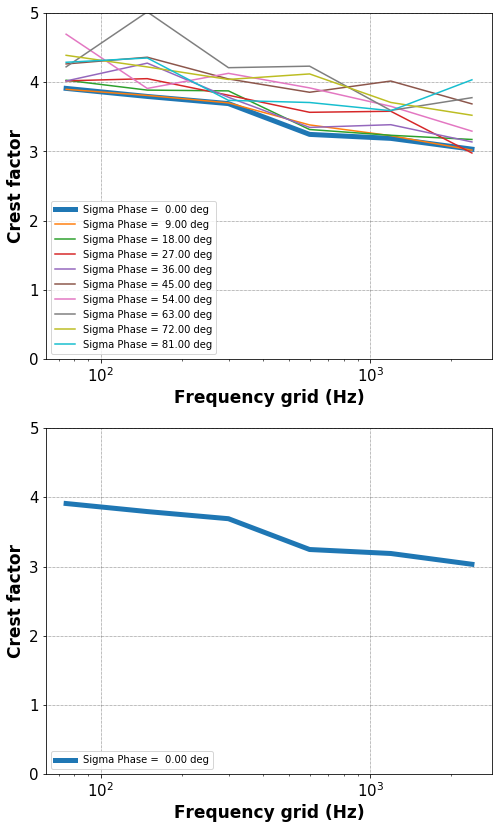

In [4]:
Fres=Fs/2**18
f,phi=compute_Cf_for_a_conf(Niter=10, Fsig=2e3, Fres=Fres)
#phase_impact(f,phi,Fres,nsteps=10)
grid_and_phase_impact(n_grid=6, n_phase=10, Niter=200, verbose=False)

In [5]:
# Crest factor as a function of the number of carriers
Nmax=40
Niter=40
Fres=Fs/2**18 # 76.29Hz
Npts=int(Fs/Fres)
Cf=np.zeros(Nmax+1)
Cf_worst=np.zeros(Nmax+1)
tempo=np.zeros(Niter)
for i in range(Nmax):
    Ncar=i+1
    Cf_worst[Ncar]=crest_factor(make_worst_bias(Ncar, Npts, Fres))
    for j in range(Niter):
        tempo[j]=crest_factor(make_bias(Ncar, Npts, Fres))
    Cf[Ncar]=np.min(tempo)
#fig, ax = plt.subplots()

fig = plt.figure(figsize=(9, 7)) 
ax = plt.subplot(1,1,1)

ax.plot(1+np.arange(Nmax), Cf[1:])
ax.plot(1+np.arange(Nmax), Cf[1:], 'o', label='Optimized Cf (random)')
ax.plot(1+np.arange(Nmax), Cf_worst[1:])
ax.plot(1+np.arange(Nmax), Cf_worst[1:], 'o', label='Non optimized Cf')
ax.set_ylim([0, Cf_worst[-1]])
ax.grid(color='k', linestyle=':', linewidth=0.5)
ax.set_xlabel("Number of carriers")
ax.set_ylabel("Crest factor")
ax.legend(loc=0, shadow=True)


NameError: name 'make_worst_bias' is not defined

* For more than 10 carriers the optimised crest factor does not depend on the number of carriers.

In [6]:
# Impact of carrier frequency resolution on crest factor
def Cf_vs_Fres(Fsig):
    Fres=Fs/np.array([2**9, 2**10, 2**11, 2**12, 2**13, 2**14, 2**15, 2**16, 2**17, 2**18])
    Ncar=40
    Npts=Fs/Fres
    Niter=120
    Cf=np.zeros(len(Fres))
    tempo=np.zeros(Niter)
    for i in range(len(Fres)):
        for j in range(Niter):
            tempo[j]=crest_factor(make_bias(Ncar, int(Npts[i]), Fres[i], Fsig))
        Cf[i]=np.min(tempo)
    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(9, 7)) 
    ax = plt.subplot(1,1,1)

    ax.semilogx(Fres, Cf)
    ax.semilogx(Fres, Cf, 'o')
    ax.set_title("Optimised Cf as a function of Fres")
    ax.set_xlabel("Frequency resolution (Hz)")
    ax.set_ylabel("Crest factor")
    ax.set_ylim([0, Cf[-1]*1.2])
    ax.grid(color='k', linestyle=':', linewidth=0.5)
    fig, ax2 = plt.subplots()
    ax2.semilogx(Fsig/Fres, Cf)
    ax2.semilogx(Fsig/Fres, Cf, 'o')
    ax2.set_title("Optimised Cf as a function of Fres")
    ax2.set_xlabel("F spread / F res")
    ax2.set_ylabel("Crest factor")
    ax2.set_ylim([0, Cf[-1]*1.2])
    ax2.grid(color='k', linestyle=':', linewidth=0.5)

    print("Cf reduction vs 4.5 for Fsig = {0:6.2f} kHz".format(Fsig))
    print("------------------------------")
    for i in range(len(Fres)):
        print("| {0:8.2f} Hz  =>> {1:6.2f} dB |".format(Fres[i], 20*np.log10(4.5/Cf[i])))
    print("------------------------------")


In [7]:
# Impact of carrier frequency spread on crest factor
def Cf_vs_Fsig(Fres):
    Fsig=np.array([250, 500, 1e3, 2e3, 4e3, 8e3, 16e3])
    Ncar=40
    Npts=Fs/Fres
    Niter=120
    Cf=np.zeros(len(Fsig))
    tempo=np.zeros(Niter)
    for i in range(len(Fsig)):
        for j in range(Niter):
            tempo[j]=crest_factor(make_bias(Ncar, int(Npts), Fres, Fsig[i]))
        Cf[i]=np.min(tempo)
    fig, ax = plt.subplots()
    ax.semilogx(Fsig, Cf)
    ax.semilogx(Fsig, Cf, 'o')
    ax.set_ylim([0, Cf[-1]*1.2])
    ax.grid(color='k', linestyle=':', linewidth=0.5)
    ax.set_title("Optimised Cf as a function of F spread")
    ax.set_xlabel("Frequency spread (Hz)")
    ax.set_ylabel("Crest factor")
    ax.grid(color='k', linestyle=':', linewidth=0.5)
    

In [8]:
# Impact of carrier frequency spread / frequency resolution on crest factor
def Cf_vs_Fsig_Fres():
    Fres=Fs/np.array([2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14, 2**15, 2**16, 2**17, 2**18])
    Fsig_over_Fres=np.array([1./128., 1./8., 1./4., 1./2., 1., 2., 4., 8.])
    Ncar=40
    Npts=Fs/Fres
    Niter=120
    Cf=np.zeros((len(Fsig_over_Fres), len(Fres)))
    tempo=np.zeros(Niter)
    for i in range(len(Fres)):
        for k in range(len(Fsig_over_Fres)):
            for j in range(Niter):
                tempo[j]=crest_factor(make_bias(Ncar, int(Npts[i]), Fres=Fres[i], Fsig=Fres[i]*Fsig_over_Fres[k]))
            Cf[k, i]=np.min(tempo)
    fig, ax = plt.subplots()
    for k in range(len(Fsig_over_Fres)):
        ax.semilogx(Fres, Cf[k,:],'-', color=c[k])
        ax.semilogx(Fres, Cf[k,:], 'o', color=c[k], label='Fsig / Fres={0:5.2f}'.format(Fsig_over_Fres[k]))
    ax.set_ylim([0, np.max(Cf*1.2)])
    ax.grid(color='k', linestyle=':', linewidth=0.5)
    ax.set_title("Optimised Cf as a function of F spread")
    ax.set_xlabel("Frequency resolution (Hz)")
    ax.set_ylabel("Crest factor")
    ax.grid(color='k', linestyle=':', linewidth=0.5)
    ax.legend(loc=0, shadow=True)
    

In [9]:
Cf_vs_Fsig(Fres=Fs/2**18)

TypeError: 'float' object cannot be interpreted as an integer

* The crest factor increases with the frequency spread around the target 100kHz grid

In [ ]:
Cf_vs_Fres(Fsig=1e3)

* The crest factor is smaller for highest values of the frequency resolution

In [ ]:
Cf_vs_Fsig_Fres()

* For values of the frequency resolution much smaller than the frequency spacing (i.e. << 100kHz, left part of the plot) the crest factor depends only on the ratio _frequency spread / frequency resolution_ : in this case the crest factor is optimal for _frequency resolution >> frequency spread_
* For values of the frequency resolution of the order of the frequency spacing (i.e. ~100kHz, right part of the plot) the crest factor is optimal whatever the ratio _frequency spread / frequency resolution_

In [ ]:
compute_Cf_for_a_conf(Ncar=40, Niter=200, Fsig=1e3, Fres=Fs/2**8)

## Summary: 
* For more than 10 carriers the optimised crest factor does not depend on the number of carriers
* The crest factor increases with the frequency spread around the target 100kHz grid
* The crest factor is smaller for highest values of the frequency resolution
* For values of the frequency resolution much smaller than the frequency spacing (i.e. << 100kHz) the crest factor depends only on the ratio _frequency spread / frequency resolution_ : in this case the crest factor is optimal for _frequency resolution >> frequency spread_
* For values of the frequency resolution of the order of the frequency spacing (i.e. ~100kHz) the crest factor is optimal whatever the ratio _frequency spread / frequency resolution_

In [8]:
def print_vect40(vect_40):
    for l in range(4):
        print("    ", end='')
        for c in range(8):
            print("{0:14.7f}, ".format(vect_40[8*l+c]), end='')
        print("")
    # Cas de la derniere ligne sans virgule a la fin
    print("    ", end='')
    for c in range(7):
        print("{0:14.7f}, ".format(vect_40[32+c]), end='')
    print("{0:14.7f} ".format(vect_40[39]))

Npts=2**13
Fres=Fs/Npts
Niter=1000
Cf_opt, Cf_mean, bias, freq, phase_opt=make_bias(Npts, Fres, Niter)
print('Best Cf:   {0:6.4f}'.format(Cf_opt))
print('Mean Cf:   {0:6.4f}'.format(Cf_mean))
print("freqtab=[")
print_vect40(freq)
print("];")

print("phitab=[")
print_vect40(phase_opt*180/np.pi)
print("];")


Best Cf:   2.8736
Mean Cf:   3.5584
freqtab=[
    996525.8789062, 1094271.2402344, 1196784.6679688, 1299298.0957031, 1399427.4902344, 1499556.8847656, 1599686.2792969, 1697431.6406250, 
    1799945.0683594, 1902458.4960938, 2000203.8574219, 2097949.2187500, 2198078.6132812, 2300592.0410156, 2400721.4355469, 2498466.7968750, 
    2600980.2246094, 2696341.5527344, 2798854.9804688, 2896600.3417969, 2996729.7363281, 3099243.1640625, 3199372.5585938, 3299501.9531250, 
    3397247.3144531, 3499760.7421875, 3602274.1699219, 3697635.4980469, 3800148.9257812, 3897894.2871094, 3998023.6816406, 4100537.1093750, 
    4200666.5039062, 4296027.8320312, 4400925.2929688, 4498670.6542969, 4598800.0488281, 4698929.4433594, 4799058.8378906, 4899188.2324219 
];
phitab=[
       107.7727850,    203.1627632,    298.8801967,    127.5994160,    188.5333522,      2.4112296,     67.1484022,    171.1652201, 
       150.8047598,    322.1950151,    130.0851989,     81.4760375,    122.0745452,     50.3190029,    241